In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import bambi as bmb
import xarray as xr
import random
import rpy2 
%load_ext rpy2.ipython

In [2]:
df = pd.read_csv('../data/Bergeron_et_al_2023_generationtimes_and_mutationrate.csv', sep=';',decimal=',')

In [3]:
df['m_generation']=df['Mutation rate per site per generation (m_generation)']

In [4]:
df['m_generation'] = pd.to_numeric(df['m_generation'])
df['Avg_age'] = pd.to_numeric(df['Avg_age'])

In [5]:
species_list=['Pan_troglodytes','Hylobates_lar','Homo_sapiens','Pithecia_pithecia','Mandrillus_leucophaeus','Saimiri_boliviensis_boliviensis']
primates = df[df['Species_name'].isin(species_list)]

In [8]:
primates.to_csv('../data/primates_bergeron2023.csv')

Basic Model 

In [6]:
basic_model = pm.Model()

with basic_model:
    alpha = pm.Normal('alpha',mu = 0, sigma = 0.1)
    beta = pm.Normal('beta',mu = 0, sigma = 0.1)
    sigma = pm.Exponential('sigma', lam=0.001)
    #expected outcome
    mu = alpha + beta * (primates['Avg_age'])
    # likelihood (sampling distribution) of observations 
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=primates['m_generation'])

In [7]:
with basic_model:
    trace_basic = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 346 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


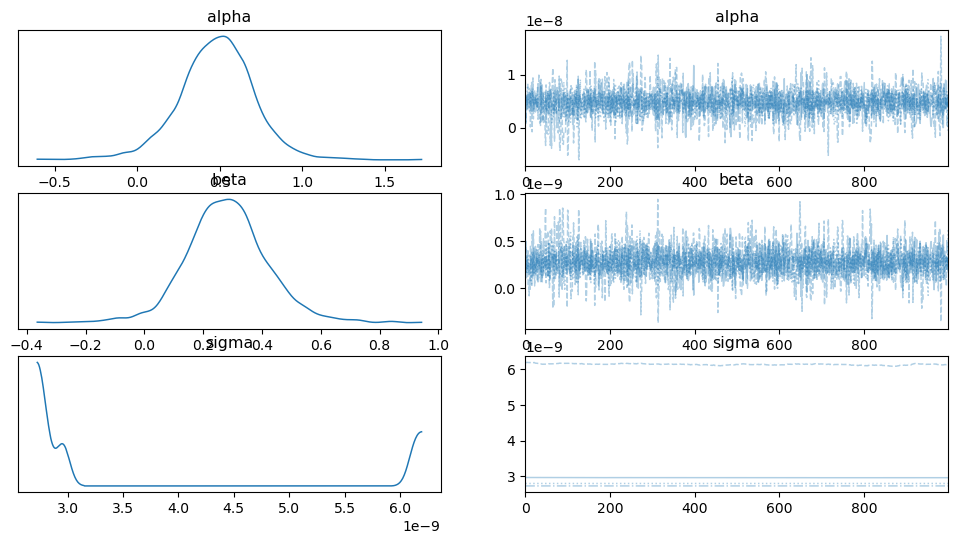

In [8]:
az.plot_trace(trace_basic, combined=True);

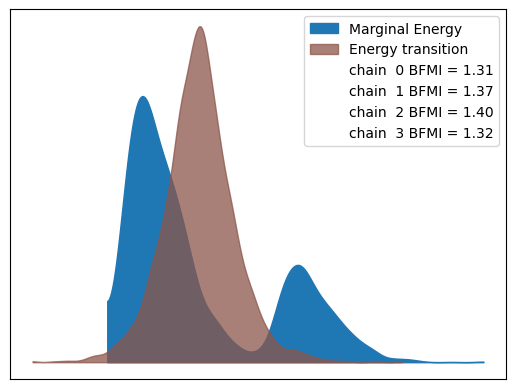

In [9]:
az.plot_energy(trace_basic);

In [10]:
alpha_vec = trace_basic.posterior["alpha"].to_numpy().reshape(-1)
beta_vec = trace_basic.posterior["beta"].to_numpy().reshape(-1)

In [11]:
sample = 1000
matrix = [[] for i in range(1000)]
for i in range(sample):
    matrix[i]=[]
    for j in np.arange(1,30,0.2):
        matrix[i].append(random.choice(alpha_vec)+random.choice(beta_vec)*j)
sampled_points_basic=np.array(matrix)


In [12]:
alpha_m = alpha_vec.mean()
beta_m = beta_vec.mean()

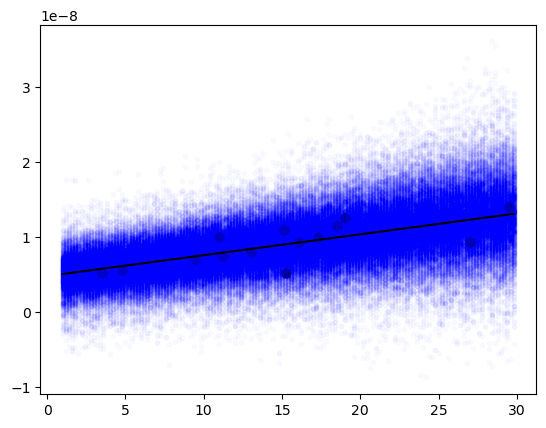

In [13]:
x= np.arange(1,30,0.2)
for i in range(1000):
    y=sampled_points_basic[i]
    plt.plot(x, y, 'b.',alpha=0.02);
plt.plot(x, alpha_vec.mean() + beta_vec.mean() *x, c='k', label='y = {:.2f} + {:.2f}* x'.format(alpha_m, beta_m))
plt.scatter(primates['Avg_age'],primates['m_generation'],color='black',alpha=1)

Log model 

In [14]:
log_scaled_g = pm.Model()

with log_scaled_g:
    alpha = pm.Normal('alpha',mu = 0, sigma = 0.1)
    beta = pm.Normal('beta',mu = 0, sigma = 0.1)
    sigma = pm.Exponential('sigma', lam=0.001)
    x = pm.MutableData("x", primates['Avg_age'])
    #expected outcome
    mu = alpha + beta * np.log10(x)
    # likelihood (sampling distribution) of observations 
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=primates['m_generation'])

In [15]:
with log_scaled_g:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 287 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


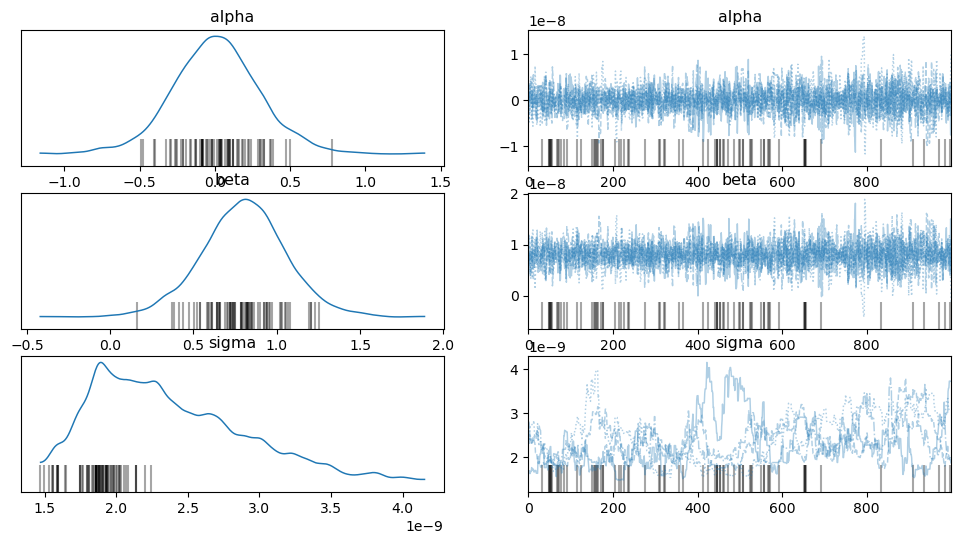

In [16]:
az.plot_trace(trace, combined=True);

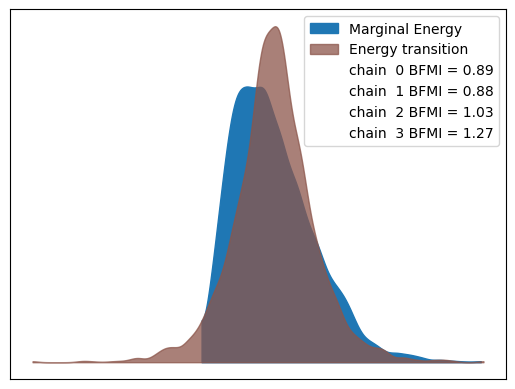

In [17]:
az.plot_energy(trace);

In [18]:
alpha_vec = trace.posterior["alpha"].to_numpy().reshape(-1)

In [19]:
beta_vec = trace.posterior["beta"].to_numpy().reshape(-1)

In [20]:
sample = 1000
matrix = [[] for i in range(1000)]
for i in range(sample):
    matrix[i]=[]
    for j in np.arange(1,30,0.2):
        matrix[i].append(random.choice(alpha_vec)+random.choice(beta_vec)*np.log10(j))
sampled_points=np.array(matrix)


In [21]:
alpha_vec.mean()

7.241679669765208e-11

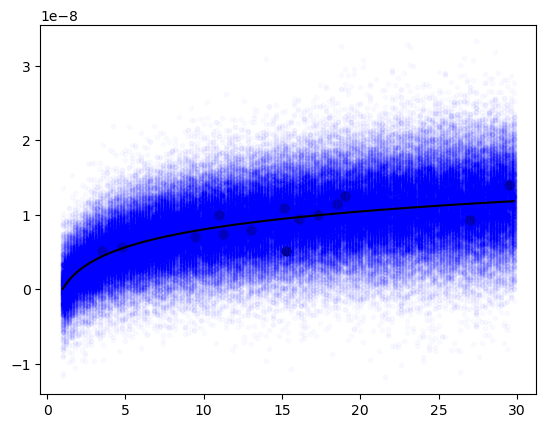

In [22]:
x= np.arange(1,30,0.2)
for i in range(1000):
    y=sampled_points[i]
    plt.plot(x, y, 'b.',alpha=0.02);
plt.plot(x, alpha_vec.mean() + beta_vec.mean() * np.log10(x), c='k', label='y = {:.2f} + {:.2f}* x'.format(alpha_m, beta_m))
plt.scatter(primates['Avg_age'],primates['m_generation'],color='black',alpha=1)

The index is the names of the models taken from the keys of the dictionary passed to compare(.).
rank, the ranking of the models starting from 0 (best model) to the number of models.

loo, the values of LOO (or WAIC). The DataFrame is always sorted from best LOO/WAIC to worst.

p_loo, the value of the penalization term. We can roughly think of this value as the estimated effective number of parameters (but do not take that too seriously).

d_loo, the relative difference between the value of LOO/WAIC for the top-ranked model and the value of LOO/WAIC for each model. For this reason we will always get a value of 0 for the first model.

weight, the weights assigned to each model. These weights can be loosely interpreted as the probability of each model being true (among the compared models) given the data.

se, the standard error for the LOO/WAIC computations. The standard error can be useful to assess the uncertainty of the LOO/WAIC estimates. By default these errors are computed using stacking.

dse, the standard errors of the difference between two values of LOO/WAIC. The same way that we can compute the standard error for each value of LOO/WAIC, we can compute the standard error of the differences between two values of LOO/WAIC.
Notice that both quantities are not necessarily the same, the reason is that the uncertainty about LOO/WAIC is correlated between models. This quantity is always 0 for the top-ranked model.

warning, If True the computation of LOO/WAIC may not be reliable.

loo_scale, the scale of the reported values. The default is the log scale as previously mentioned. Other options are deviance – this is the log-score multiplied by -2 (this reverts the order: a lower LOO/WAIC will be better) – and negative-

log – this is the log-score multiplied by -1 (as with the deviance scale, a lower value is better).

##Predictions on generation times for all species:

Generation times from Kuderna et al 2023 'global catelog' 

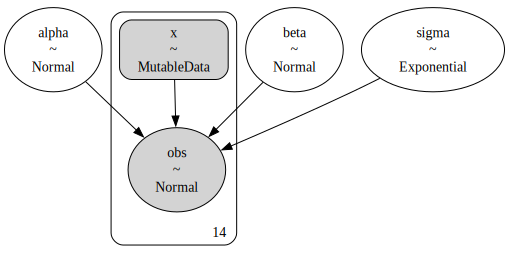

In [23]:
pm.model_to_graphviz(log_scaled_g)

In [24]:
halfnormal = pm.Model()

with halfnormal:
    alpha = pm.HalfNormal('alpha',sigma = 0.1)
    beta = pm.Normal('beta',mu = 0, sigma = 0.1)
    sigma = pm.Exponential('sigma', lam=0.001)
    x = pm.MutableData("x", primates['Avg_age'])
    #expected outcome
    mu = alpha + beta * np.log10(x)
    # likelihood (sampling distribution) of observations 
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=primates['m_generation'])

In [25]:
with halfnormal:
    trace_half = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 625 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [41]:
trace_half.to_netcdf("../results/model/half_normal_log_model.nc")

'../results/model/half_normal_log_model.nc'

In [42]:
trace.to_netcdf("../results/model/log_scaled_g_model.nc")


'../results/model/log_scaled_g_model.nc'

In [44]:
trace_basic.to_netcdf("../results/model/basic_model.nc")

'../results/model/basic_model.nc'

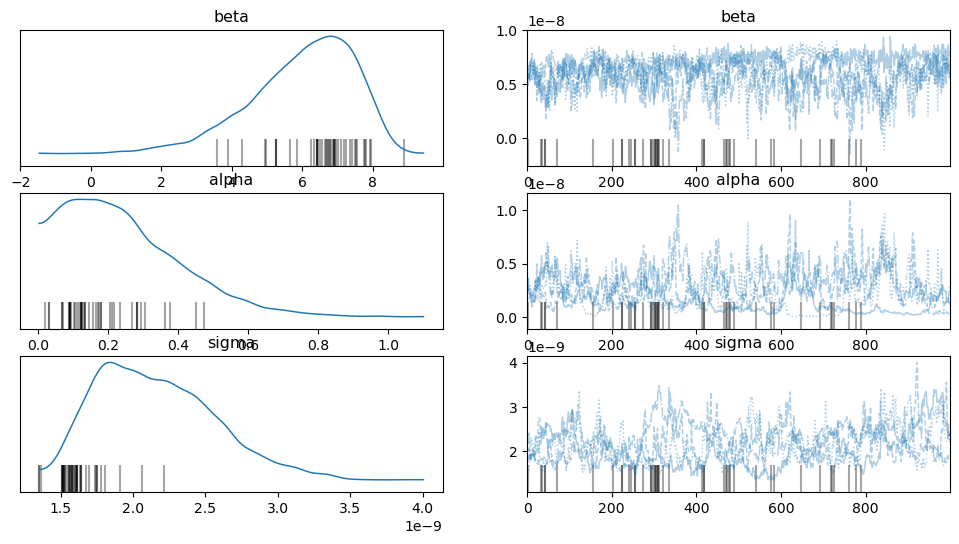

In [26]:
az.plot_trace(trace_half, combined=True);

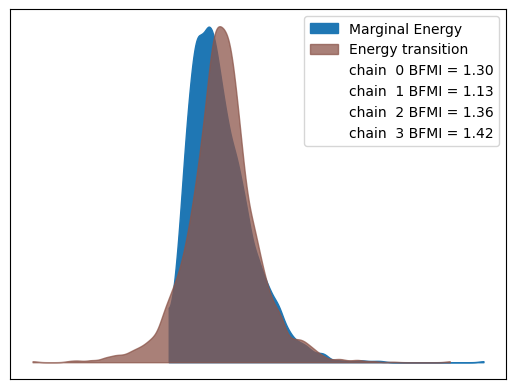

In [27]:
az.plot_energy(trace_half);

In [28]:
alpha_vec = trace_half.posterior["alpha"].to_numpy().reshape(-1)
beta_vec = trace_half.posterior["beta"].to_numpy().reshape(-1)
# Create DataFrames
alpha_df = pd.DataFrame({'alpha': alpha_vec})
beta_df = pd.DataFrame({'beta': beta_vec})

# Save to CSV
alpha_df.to_csv('../results/model/alphas.csv', index=False)
beta_df.to_csv('../results/model/betas.csv', index=False)

In [29]:
sample = 1000
matrix = [[] for i in range(1000)]
for i in range(sample):
    matrix[i]=[]
    for j in np.arange(1,30,0.2):
        matrix[i].append(random.choice(alpha_vec)+random.choice(beta_vec)*np.log10(j))
sampled_points=np.array(matrix)

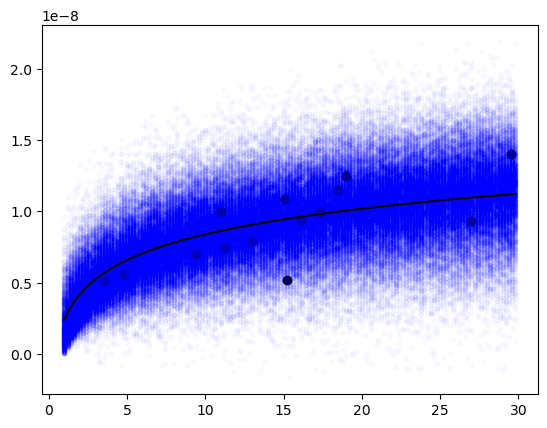

In [30]:
x= np.arange(1,30,0.2)
for i in range(1000):
    y=sampled_points[i]
    plt.plot(x, y, 'b.',alpha=0.02);
plt.plot(x, alpha_vec.mean() + beta_vec.mean() * np.log10(x), c='k', label='y = {:.2f} + {:.2f}* x'.format(alpha_m, beta_m))
plt.scatter(primates['Avg_age'],primates['m_generation'],color='black',alpha=1)

MODEL COMPARISON

In [31]:
with halfnormal:
    pm.compute_log_likelihood(trace_half)
with basic_model:
    pm.compute_log_likelihood(trace_basic)
with log_scaled_g:
    pm.compute_log_likelihood(trace)

In [45]:
df_comp_loo = az.compare({"basic_model": trace_basic, "log_scaled_g": trace, 'halfnormal':trace_half})
df_comp_loo.to_csv('../results/model/comparison.csv')



/home/bjarkemp/miniforge3/envs/bircproject/lib/python3.10/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/bjarkemp/miniforge3/envs/bircproject/lib/python3.10/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


IsADirectoryError: [Errno 21] Is a directory: '../results/model/'

In [46]:
df_comp_loo.to_csv('../results/model/comparison.csv')


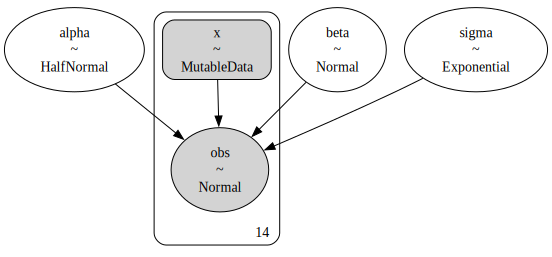

In [33]:
pm.model_to_graphviz(halfnormal)

The index is the names of the models taken from the keys of the dictionary passed to compare(.). rank, the ranking of the models starting from 0 (best model) to the number of models.

loo, the values of LOO (or WAIC). The DataFrame is always sorted from best LOO/WAIC to worst.

p_loo, the value of the penalization term. We can roughly think of this value as the estimated effective number of parameters (but do not take that too seriously).

d_loo, the relative difference between the value of LOO/WAIC for the top-ranked model and the value of LOO/WAIC for each model. For this reason we will always get a value of 0 for the first model.

weight, the weights assigned to each model. These weights can be loosely interpreted as the probability of each model being true (among the compared models) given the data.

se, the standard error for the LOO/WAIC computations. The standard error can be useful to assess the uncertainty of the LOO/WAIC estimates. By default these errors are computed using stacking.

dse, the standard errors of the difference between two values of LOO/WAIC. The same way that we can compute the standard error for each value of LOO/WAIC, we can compute the standard error of the differences between two values of LOO/WAIC. Notice that both quantities are not necessarily the same, the reason is that the uncertainty about LOO/WAIC is correlated between models. This quantity is always 0 for the top-ranked model.

warning, If True the computation of LOO/WAIC may not be reliable.

loo_scale, the scale of the reported values. The default is the log scale as previously mentioned. Other options are deviance – this is the log-score multiplied by -2 (this reverts the order: a lower LOO/WAIC will be better) – and negative-

log – this is the log-score multiplied by -1 (as with the deviance scale, a lower value is better).

POSTERIOR PREDICTIVE CHECK

In [34]:
with halfnormal:
    pm.sample_posterior_predictive(trace_half, extend_inferencedata=True)

Sampling: [obs]


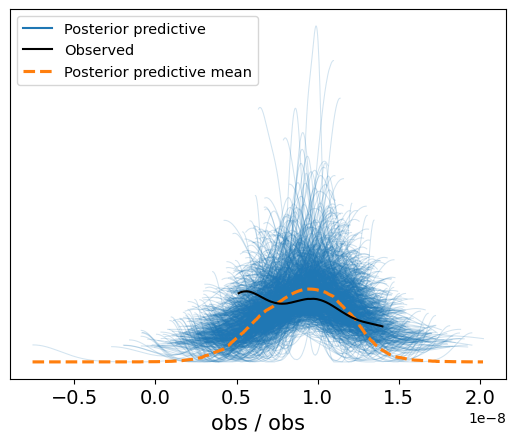

In [35]:
az.plot_ppc(trace_half, num_pp_samples=1000);

In [36]:
with log_scaled_g:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [obs]


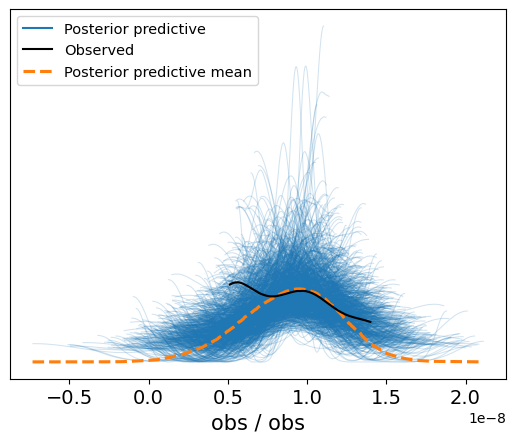

In [37]:
az.plot_ppc(trace, num_pp_samples=1000);

In [38]:
with basic_model:
    pm.sample_posterior_predictive(trace_basic, extend_inferencedata=True)

Sampling: [obs]


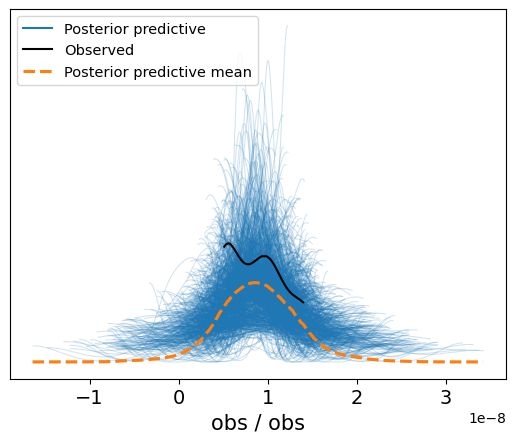

In [39]:
az.plot_ppc(trace_basic, num_pp_samples=1000);